In [1]:
%matplotlib inline
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy.visualization import simple_norm
from astropy import wcs
from astropy import table
from astropy.io import fits
from astropy import units as u
import PIL
import regions
import pyavm
import numpy as np
import pylab as pl
pl.rcParams['figure.facecolor'] = 'w'
pl.rcParams['image.origin'] = 'lower'
pl.rcParams['figure.figsize'] = (10,8)
pl.rcParams['figure.dpi'] = 100
pl.rcParams['font.size'] = 16

In [2]:
from astroquery.vizier import Vizier

In [3]:
basepath = '/orange/adamginsburg/jwst/brick/'

In [60]:
import sys, imp
sys.path.append(f'{basepath}/analysis/')
import plot_tools
imp.reload(plot_tools)

<module 'plot_tools' from '/orange/adamginsburg/jwst/brick//analysis/plot_tools.py'>

In [61]:
from plot_tools import starzoom, make_sed

In [6]:
basetable = Table.read(f'{basepath}/catalogs/crowdsource_nsky0_merged_photometry_tables_merged.fits')

In [7]:
filternames = ['f410m', 'f212n', 'f466n', 'f405n', 'f187n', 'f182m']

In [8]:
any_saturated_ = [basetable[x] for x in basetable.colnames if 'near_sat' in x]
any_saturated = any_saturated_[0]
for row in any_saturated_[1:]:
    #print(row.sum())
    any_saturated = any_saturated | row
magerr_gtpt1 = np.logical_or.reduce([basetable[f'emag_ab_{filtername}'] > 0.2 for filtername in filternames])

In [9]:
oksep = np.logical_or.reduce([basetable[f'sep_{filtername}'] for filtername in filternames[1:]])
blue_410_466 = oksep & ~any_saturated & (~(basetable['mag_ab_410m405'].mask)) & ((basetable['mag_ab_410m405'] - basetable['mag_ab_f466n']) + (basetable['emag_ab_f410m']**2 + basetable['emag_ab_f466n']**2 + basetable['emag_ab_f405n']**2)**0.5 < -1.75)
assert (blue_410_466 & basetable['mag_ab_410m405'].mask).sum() == 0
blue_410_405 = oksep & ~any_saturated & (~(basetable['mag_ab_410m405'].mask)) & ((basetable['mag_ab_410m405'] - basetable['mag_ab_f405n']) + (basetable['emag_ab_f410m']**2 + basetable['emag_ab_f405n']**2)**0.5 < -2)
blue_405_410 = oksep & ~any_saturated & (~(basetable['mag_ab_410m405'].mask)) & ((basetable['mag_ab_405m410'] - basetable['mag_ab_410m405']) + (basetable['emag_ab_f410m']**2 + basetable['emag_ab_f405n']**2)**0.5 < -3)
blue_405_410b = oksep & ~any_saturated & (basetable['flux_f405n'] > basetable['flux_f410m']) & (~(basetable['mag_ab_f405n'].mask)) & ((basetable['mag_ab_f405n'] - basetable['mag_ab_f410m']) + (basetable['emag_ab_f410m']**2 + basetable['emag_ab_f405n']**2)**0.5 < -2) & ~magerr_gtpt1

In [10]:
blue_410_466.sum(), blue_405_410.sum(), blue_405_410b.sum()

(1007, 1796, 4125)

In [11]:
viz = Vizier()

In [12]:
bluetbl = basetable[blue_410_466]
bluetbl.sort('flux_f410m')
bluetbl[-5:]

<Table length=5>
     x_f410m            y_f410m       flux_f410m passno_f410m    dx_f410m      dy_f410m   dflux_f410m   qf_f410m   rchi2_f410m ... near_saturated_f182m flux_jy_410m405 mag_ab_410m405 flux_jy_405m410 mag_ab_405m410 flux_jy_182m187 mag_ab_182m187 flux_jy_187m182 mag_ab_187m182
                                                                                                                               ...                             Jy                             Jy                             Jy                             Jy                     
     float64            float64        float32     float64       float32       float32      float32     float32      float32   ...         bool             float32        float32         float32        float32         float32        float32         float32        float32    
------------------ ------------------ ---------- ------------ ------------- ------------- ----------- ------------ ----------- ... -------------------- --------------- -------------- --------------- -------------- --------------- -------------- --------------- --------------
2820.0014960726403 2293.0546800424922   76382.08          0.0  0.0038644252   0.004026979   130.10335   0.02549865   50003.117 ...                False      0.07706219      11.682897     -0.06458749             --   -6.206108e-05             --   0.00042624364      17.325855
1550.9029048996115 2287.5701596316567   371050.3          0.0  0.0041963877   0.003415794     541.029 0.0017791213   131986.14 ...                False      0.38648775        9.93216     -0.40065706             --   0.00040834735      17.372425   0.00023969437      17.950855
110.79141187667847  2107.429160386324  404166.47          0.0 0.00088193297  0.0008932613    128.1039  0.023314768  128387.555 ...                False      0.41585433       9.852647     -0.39639014             --   0.00058878015      16.975117   1.1580589e-05      21.240673
2932.8489813655615  34.86459346115589   636060.7          0.0  0.0004696864 0.00038342565   136.62117   0.02381796     98724.9 ...                False       0.6922646       9.299319       -0.903123             --    0.0005519113      17.045326    0.0076320143      14.193402
 1552.710868537426 2281.7366507947445  649344.44          0.0   0.000872484  0.0005820806   340.17804  0.005865639   134735.02 ...                False       0.7403085       9.226468      -1.1619242             --   -0.0011190618             --     0.008063272      14.133721

In [13]:
fov = regions.Regions.read(f'{basepath}/regions/nircam_fov.reg')

In [14]:
coord = fov[0].center
height = fov[0].height
width = fov[0].width
height, width = width, height # CARTA wrote it wrong
coord, width, height

(<SkyCoord (ICRS): (ra, dec) in deg
     (266.53496367, -28.71007499)>,
 <Quantity 161.9038 arcsec>,
 <Quantity 391.024 arcsec>)

In [15]:
skycrds_cat = bluetbl['skycoord_f410m']

In [68]:
spitzer = Vizier(row_limit=1e6).query_region(coordinates=coord, width=width*2, height=height*2, catalog=['II/295/SSTGC'])[0]
spitzer.add_index('SSTGC')
spitzer_crds = SkyCoord(spitzer['RAJ2000'], spitzer['DEJ2000'], frame='fk5', unit=(u.hour, u.deg))
idx, sidx, sep, sep3d = spitzer_crds.search_around_sky(skycrds_cat, 1*u.arcsec)
len(spitzer), len(idx), len(sidx)

(5895, 8946, 8946)

/scratch/local/54461384/ipykernel_55608/3396868984.py:1: UserWarning: You passed a edgecolor/edgecolors ('b') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  pl.scatter(spitzer_crds.ra[sidx], spitzer_crds.dec[sidx], facecolor='b', edgecolor='b', marker='x')


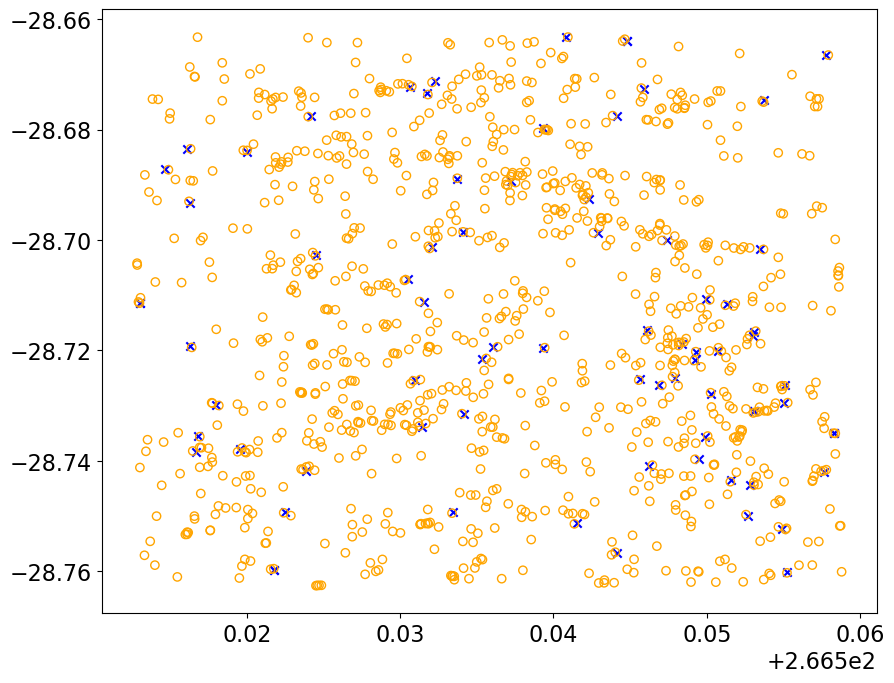

In [17]:
pl.scatter(spitzer_crds.ra[sidx], spitzer_crds.dec[sidx], facecolor='b', edgecolor='b', marker='x')
pl.scatter(skycrds_cat.ra, skycrds_cat.dec, facecolor='none', edgecolor='orange')

Set OBSGEO-B to   -20.631897 from OBSGEO-[XYZ].
Set OBSGEO-H to 1526059356.900 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


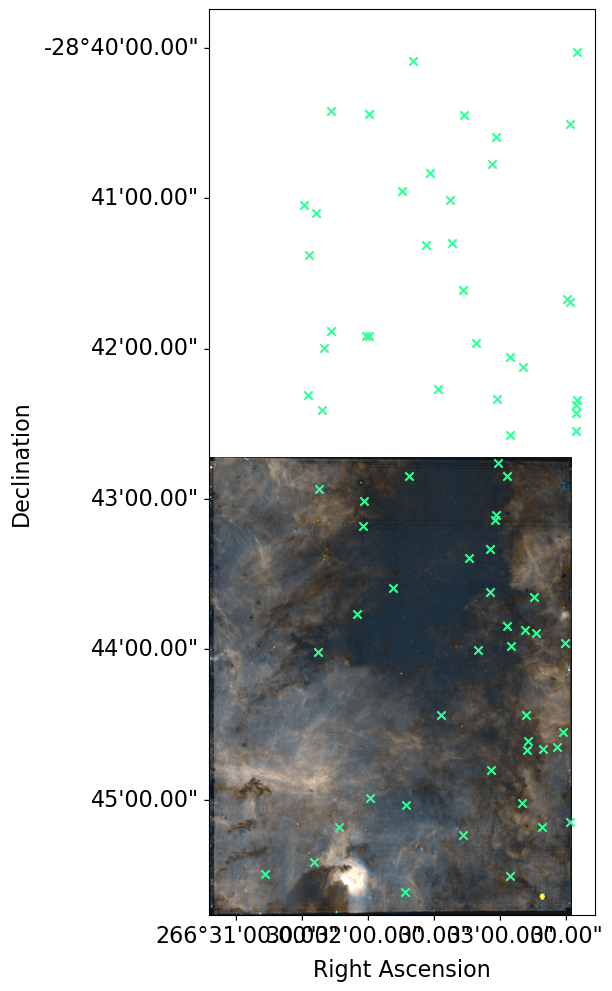

In [18]:
# This image shows only H-alpha stars
avm = pyavm.AVM.from_image(f'{basepath}/images/BrickJWST_nrca_longwave_narrowband_rotated_lighter.png')
img_narrow = np.array(PIL.Image.open(f'{basepath}/images/BrickJWST_nrca_longwave_narrowband_rotated_lighter.png'))[::-1,:,:]
#wwi_bra_410 = avm.to_wcs(use_full_header=True)
wwi_narrow = wcs.WCS(fits.Header.fromstring(avm.Spatial.FITSheader))

img_narrow = img_narrow.swapaxes(0,1)
wwi_narrow = wwi_narrow.sub([2,1])

fig = pl.figure(figsize=(12,12))
ax = pl.subplot(projection=wwi_narrow)
ax.imshow(img_narrow)

crds = basetable['skycoord_f410m']
ax.scatter(
    crds.dec[blue_410_466][idx],
    crds.ra[blue_410_466][idx],
    transform=ax.get_transform('world'),
    marker='x', facecolors=(0.2, 1, 0.6),
    #markeredgewidth=0.5,
    # for non-x facecolors='none'
    #edgecolors=(0.3, 0.5, 0.8), 
);
#ax.scatter(crds.ra[blue_410_405], crds.dec[blue_410_405], edgecolors='orange', facecolors='none', transform=ax.get_transform('world'))
ax.coords['ra'].set_axislabel('Right Ascension')
ax.coords['dec'].set_axislabel('Declination')

ra = lon = ax.coords['ra']
dec = lat = ax.coords['dec']
lon.set_major_formatter('dd:mm:ss.ss')
lat.set_major_formatter('dd:mm:ss.ss')
#lon.set_ticks(spacing=30. * u.arcsec, color='red')
#lat.set_ticks(spacing=30. * u.arcsec, color='blue')
#lon.set_ticklabel(color='red')
#lat.set_ticklabel(color='blue')
#lon.grid(color='red')
#lat.grid(color='blue')

dec.set_ticks_position('l')
dec.set_ticklabel_position('l')
dec.set_axislabel_position('l')
ra.set_ticks_position('b')
ra.set_ticklabel_position('b')
ra.set_axislabel_position('b')
#fig.savefig(f"{basepath}/images/BlueStarsWithSpitzerMatches_on_RGB.png", bbox_inches='tight')

Set DATE-AVG to '2022-08-28T03:05:32.473' from MJD-AVG.
Set DATE-END to '2022-08-28T03:34:03.557' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -20.651775 from OBSGEO-[XYZ].
Set OBSGEO-H to 1526292809.682 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


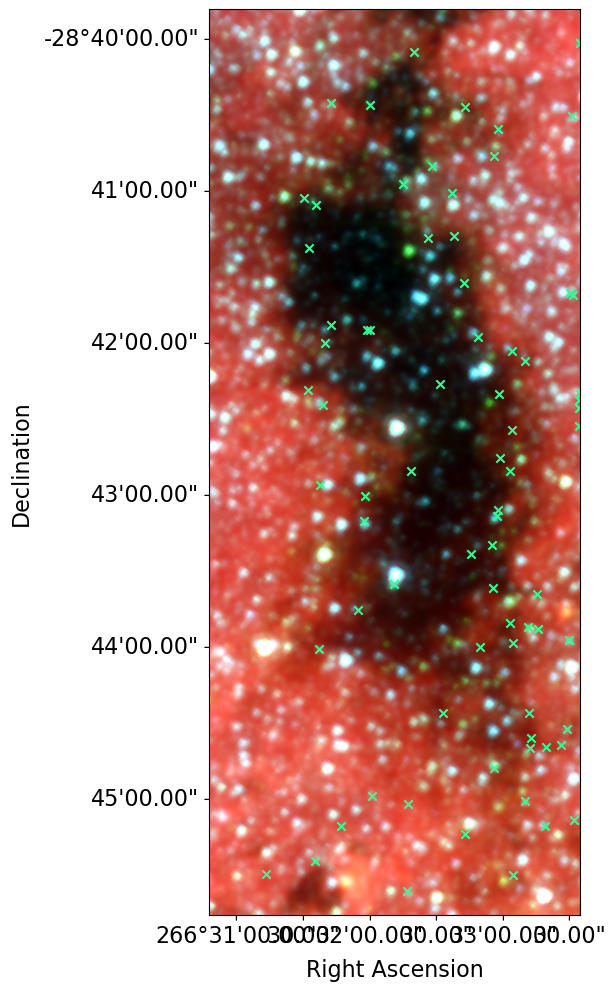

In [31]:
# This image shows only H-alpha stars
avm = pyavm.AVM.from_image(f'{basepath}/images/BrickSpitzer_RGB_I421.png')
img_spitzer = np.array(PIL.Image.open(f'{basepath}/images/BrickSpitzer_RGB_I421.png'))[::-1,:,:]
#wwi_bra_410 = avm.to_wcs(use_full_header=True)
wwi_spitzer = wcs.WCS(fits.Header.fromstring(avm.Spatial.FITSheader))

img_spitzer = img_spitzer.swapaxes(0,1)
wwi_spitzer = wwi_spitzer.sub([2,1])

fig = pl.figure(figsize=(12,12))
ax = pl.subplot(projection=wwi_spitzer)
ax.imshow(img_spitzer)

crds = basetable['skycoord_f410m']
ax.scatter(
    crds.dec[blue_410_466][idx],
    crds.ra[blue_410_466][idx],
    transform=ax.get_transform('world'),
    marker='x', facecolors=(0.2, 1, 0.6),
    #markeredgewidth=0.5,
    # for non-x facecolors='none'
    #edgecolors=(0.3, 0.5, 0.8), 
);
#ax.scatter(crds.ra[blue_410_405], crds.dec[blue_410_405], edgecolors='orange', facecolors='none', transform=ax.get_transform('world'))
ax.coords['ra'].set_axislabel('Right Ascension')
ax.coords['dec'].set_axislabel('Declination')

ra = lon = ax.coords['ra']
dec = lat = ax.coords['dec']
lon.set_major_formatter('dd:mm:ss.ss')
lat.set_major_formatter('dd:mm:ss.ss')
#lon.set_ticks(spacing=30. * u.arcsec, color='red')
#lat.set_ticks(spacing=30. * u.arcsec, color='blue')
#lon.set_ticklabel(color='red')
#lat.set_ticklabel(color='blue')
#lon.grid(color='red')
#lat.grid(color='blue')

dec.set_ticks_position('l')
dec.set_ticklabel_position('l')
dec.set_axislabel_position('l')
ra.set_ticks_position('b')
ra.set_ticklabel_position('b')
ra.set_axislabel_position('b')
#fig.savefig(f"{basepath}/images/BlueStarsWithSpitzerMatches_on_RGB.png", bbox_inches='tight')

In [32]:
spitzer[:3]

<Table length=3>
 SSTGC    RAJ2000     DEJ2000     Jmag    Hmag    Ksmag   _3.6mag _4.5mag _5.8mag _8.0mag IRAC _2M 
          'h:m:s'     'd:m:s'     mag     mag      mag      mag     mag     mag     mag            
  str7     str11       str11    float32 float32  float32  float32 float32 float32 float32 str4 str2
------- ----------- ----------- ------- -------- -------- ------- ------- ------- ------- ---- ----
0569186 17 45 56.09 -28 41 55.2      --       --       --  12.151      --      --      -- IRAC   2M
0569192 17 45 56.09 -28 41 14.7  15.762   13.059   11.779      --      --      --      -- IRAC   2M
0569193 17 45 56.09 -28 45 33.3      --       --       --  11.601  11.340  10.390      -- IRAC   2M

Text(0, 0.5, 'I2-I4')

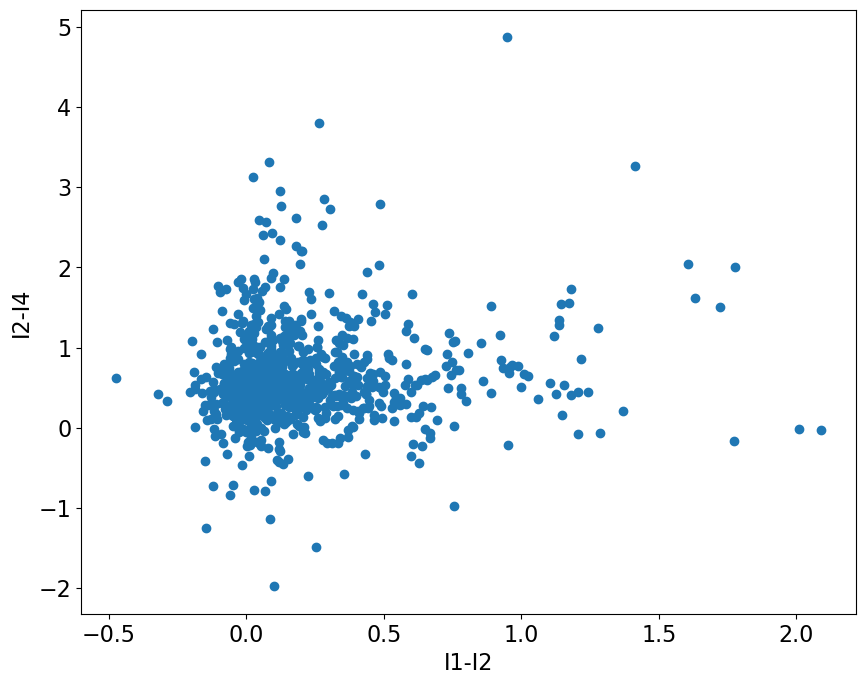

In [33]:
pl.scatter(spitzer['_3.6mag'] - spitzer['_4.5mag'],  spitzer['_4.5mag'] - spitzer['_8.0mag'])
pl.xlabel("I1-I2")
pl.ylabel("I2-I4")

Text(0, 0.5, 'I2')

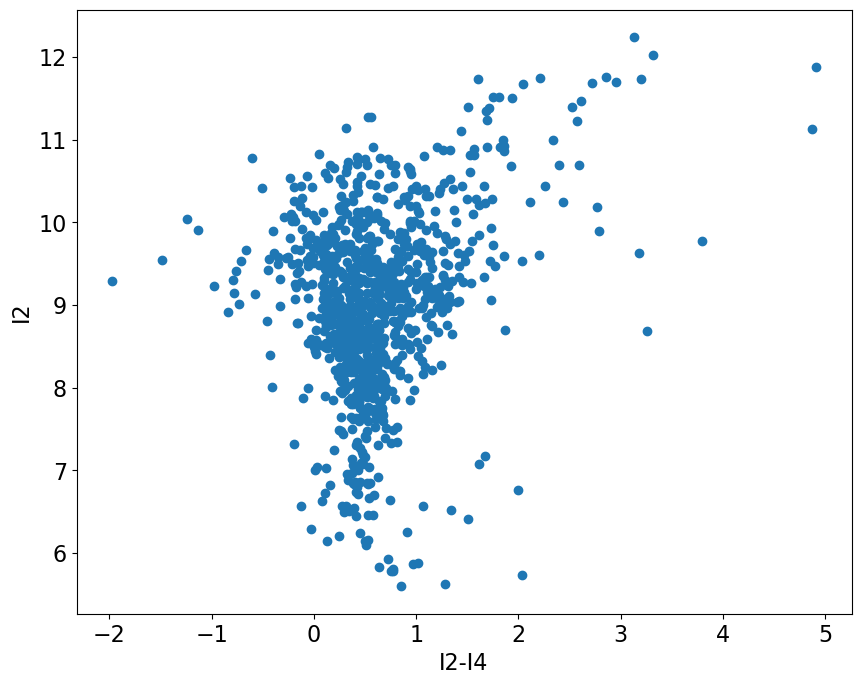

In [34]:
pl.scatter(spitzer['_4.5mag'] - spitzer['_8.0mag'],  spitzer['_4.5mag'])
pl.xlabel("I2-I4")
pl.ylabel("I2")

Text(0, 0.5, 'I2-I4')

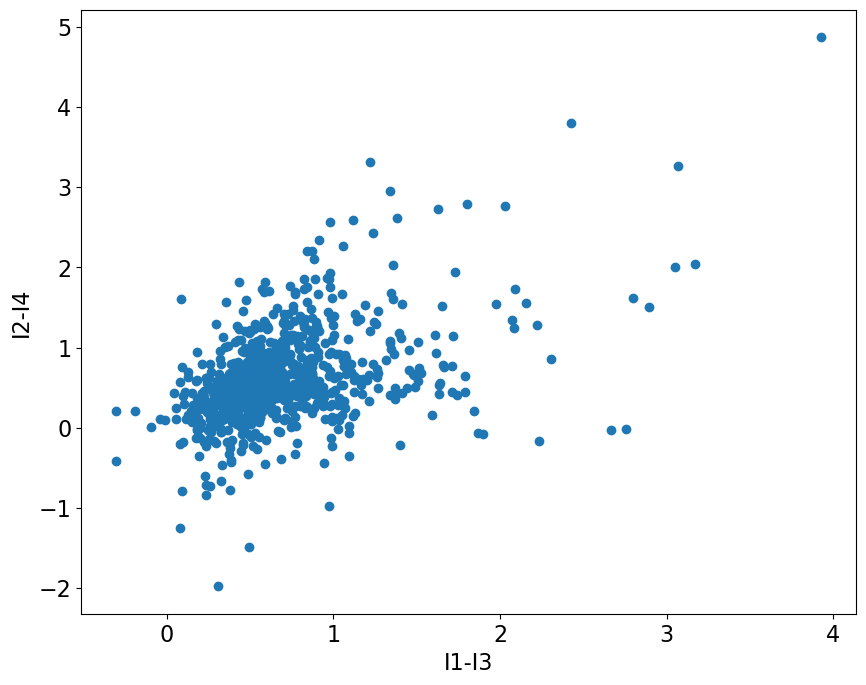

In [35]:
pl.scatter(spitzer['_3.6mag'] - spitzer['_5.8mag'],  spitzer['_4.5mag'] - spitzer['_8.0mag'])
pl.xlabel("I1-I3")
pl.ylabel("I2-I4")

In [36]:
wwi_spitzer.world_to_pixel(spitzer_crds[spitzer['_4.5mag'] - spitzer['_8.0mag'] < 0])

(array([-332.82768491, -301.69733563, -287.19583525, -290.52767802,
        -263.77138065, -249.28364559, -214.29212152, -204.57853656,
        -204.22387882, -198.03527824, -214.68760838, -188.13946848,
        -198.83658986, -186.10544106, -166.00340542, -172.64529091,
        -153.95404284, -141.15530161, -154.95132734, -112.267619  ,
        -118.41017824,  -65.23103375,  -83.19412959,  -66.61151222,
         -39.94478493,  -45.72849267,   -9.38995358,  -23.75073262,
         -16.84926654,    4.66086104,    7.54781251,    6.94763763,
          26.45448607,   20.32406318,   40.98150225,   66.08498449,
          93.94570011,  128.4231984 ,  148.99170627,  123.09552557,
         188.01760923,  176.98983891,  196.08575698,  260.12709179,
         262.48012072,  277.73480409,  315.53324653,  382.75976696,
         399.37301432,  411.1733778 ,  398.56227853,  440.5172092 ,
         408.05277904,  446.52683274,  478.03038045,  463.78622616,
         515.09282118,  515.68907643,  582.11651

Set DATE-AVG to '2022-08-28T03:05:32.473' from MJD-AVG.
Set DATE-END to '2022-08-28T03:34:03.557' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -20.651775 from OBSGEO-[XYZ].
Set OBSGEO-H to 1526292809.682 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


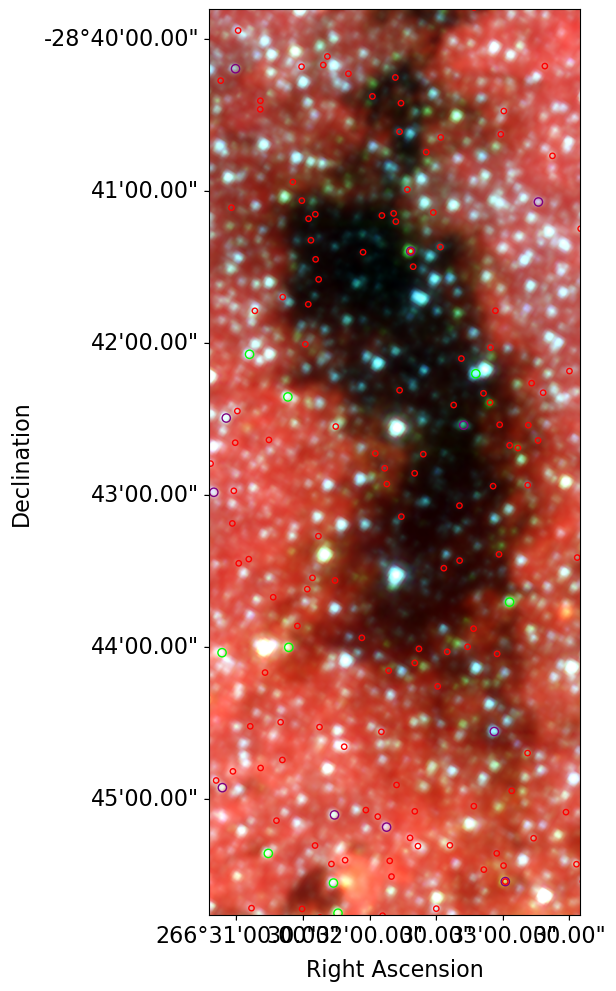

In [37]:
# This image shows only H-alpha stars
avm = pyavm.AVM.from_image(f'{basepath}/images/BrickSpitzer_RGB_I421.png')
img_spitzer = np.array(PIL.Image.open(f'{basepath}/images/BrickSpitzer_RGB_I421.png'))[::-1,:,:]
#wwi_bra_410 = avm.to_wcs(use_full_header=True)
wwi_spitzer = wcs.WCS(fits.Header.fromstring(avm.Spatial.FITSheader))

img_spitzer = img_spitzer.swapaxes(0,1)
wwi_spitzer = wwi_spitzer.sub([2,1])

fig = pl.figure(figsize=(12,12))
ax = pl.subplot(projection=wwi_spitzer)
ax.imshow(img_spitzer)
axlims = ax.axis()

green_spitzer = (spitzer['_4.5mag'] - spitzer['_8.0mag'] < 0.)
green_nored = ((spitzer['_4.5mag'] < 9) & (spitzer['_8.0mag'].mask))
xx,yy = wwi_spitzer.world_to_pixel(spitzer_crds[green_spitzer])
ax.scatter(
    xx,yy,
    #spitzer_crds.ra[spitzer['_4.5mag'] - spitzer['_8.0mag'] < 0],
    #spitzer_crds.dec[spitzer['_4.5mag'] - spitzer['_8.0mag'] < 0],
    #transform=ax.get_transform('fk5'),
    marker='o', edgecolors='purple', facecolors='none',
    #markeredgewidth=0.5,
    # for non-x facecolors='none'
    #edgecolors=(0.3, 0.5, 0.8), a 
);
xx,yy = wwi_spitzer.world_to_pixel(spitzer_crds[green_nored])
ax.scatter(
    xx,yy,
    marker='o', edgecolors='lime', facecolors='none',
);
redi1i2_spitzer = (spitzer['_3.6mag'] - spitzer['_4.5mag'] > 1.75)# | ((10 < spitzer['_4.5mag']) & (spitzer['_4.5mag'] < 15) & (spitzer['_8.0mag'].mask))
xx,yy = wwi_spitzer.world_to_pixel(spitzer_crds[redi1i2_spitzer])
ax.scatter(
    xx,yy,
    #spitzer_crds.ra[spitzer['_4.5mag'] - spitzer['_8.0mag'] < 0],
    #spitzer_crds.dec[spitzer['_4.5mag'] - spitzer['_8.0mag'] < 0],
    #transform=ax.get_transform('fk5'),
    marker='o', edgecolors='r', facecolors='none',
s=15,
    # for non-x facecolors='none'
    #edgecolors=(0.3, 0.5, 0.8), a 
);
#ax.scatter(crds.ra[blue_410_405], crds.dec[blue_410_405], edgecolors='orange', facecolors='none', transform=ax.get_transform('world'))
ax.coords['ra'].set_axislabel('Right Ascension')
ax.coords['dec'].set_axislabel('Declination')

ra = lon = ax.coords['ra']
dec = lat = ax.coords['dec']
lon.set_major_formatter('dd:mm:ss.ss')
lat.set_major_formatter('dd:mm:ss.ss')
#lon.set_ticks(spacing=30. * u.arcsec, color='red')
#lat.set_ticks(spacing=30. * u.arcsec, color='blue')
#lon.set_ticklabel(color='red')
#lat.set_ticklabel(color='blue')
#lon.grid(color='red')
#lat.grid(color='blue')

ax.axis(axlims)

dec.set_ticks_position('l')
dec.set_ticklabel_position('l')
dec.set_axislabel_position('l')
ra.set_ticks_position('b')
ra.set_ticklabel_position('b')
ra.set_axislabel_position('b')
#fig.savefig(f"{basepath}/images/BlueStarsWithSpitzerMatches_on_RGB.png", bbox_inches='tight')

In [210]:
coord = SkyCoord('17:46:08.914 -28:41:22.51', frame='fk5', unit=(u.hour, u.deg))
radius = 0.5*u.arcsec

<SkyCoord (FK5: equinox=J2000.000): (ra, dec) in deg
    (266.53714167, -28.68958611)>

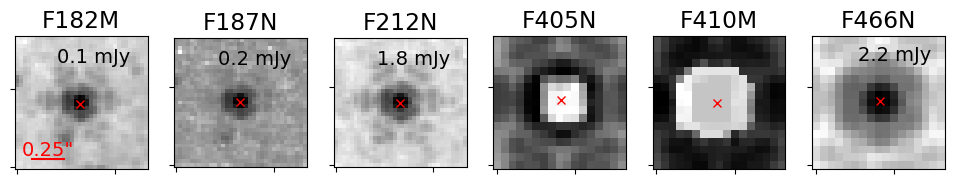

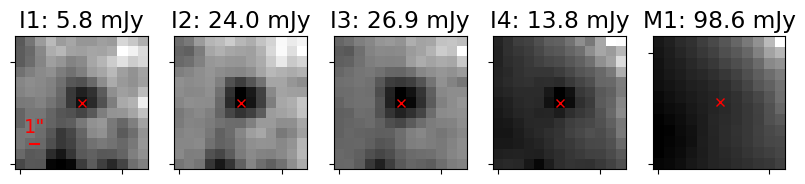

In [267]:
import sys, imp
sys.path.append(f'{basepath}/analysis/')
sys.path.append(f'{basepath}/reduction/')
import plot_tools
imp.reload(plot_tools)
from plot_tools import starzoom, make_sed, starzoom_spitzer
starzoom(coord)
starzoom_spitzer(coord)
coord

In [212]:
(coord.separation(skycrds_cat) < radius).sum()

4

In [40]:
skycrds_cat = basetable['skycoord_f410m']
idx = coord.separation(skycrds_cat) < radius
if len(idx) == 0:
    raise

spitzer = Vizier.query_region(coordinates=coord, radius=radius, catalog=['II/295/SSTGC'])[0]
if len(spitzer) > 0:
    spitzer_crds = SkyCoord(spitzer['RAJ2000'], spitzer['DEJ2000'], frame='fk5', unit=(u.hour, u.deg))
    spitzindex = coord.separation(spitzer_crds) < radius
    print(len(spitzindex))
    spitzermatch = spitzer[spitzindex]

vvvdr2 = Vizier.query_region(coordinates=coord, radius=0.5*u.arcsec, catalog=['II/348/vvv2'])[0]
if len(spitzer) > 0:
    vvvdr2_crds = SkyCoord(vvvdr2['RAJ2000'], vvvdr2['DEJ2000'], frame='fk5', unit=(u.hour, u.deg))
    vvvindex = coord.separation(vvvdr2_crds) < radius
    print(len(vvvindex))
    vvvmatch = vvvdr2[vvvindex]

1
1


In [41]:
from astroquery.svo_fps import SvoFps

In [42]:
for filtername in filternames:
    telescope = 'JWST'
    instrument = 'NIRCAM'
    wavelength_table = SvoFps.get_transmission_data(f'{telescope}/{instrument}.{filtername}')

In [43]:
spitzer[:1]

<Table length=1>
 SSTGC    RAJ2000     DEJ2000     Jmag    Hmag    Ksmag   _3.6mag _4.5mag _5.8mag _8.0mag IRAC _2M 
          'h:m:s'     'd:m:s'     mag     mag      mag      mag     mag     mag     mag            
  str7     str11       str11    float32 float32  float32  float32 float32 float32 float32 str4 str2
------- ----------- ----------- ------- -------- -------- ------- ------- ------- ------- ---- ----
0604691 17 46 08.93 -28 41 22.5  15.819   14.663   12.374  10.953   8.864   8.285   8.895 IRAC   2M

In [44]:
    skycrds_cat = basetable['skycoord_f410m']
    idx = coord.separation(skycrds_cat) < radius
    if len(idx) == 0:
        raise
    else:
        idx = np.argmin(coord.separation(skycrds_cat))

    spitzer = Vizier.query_region(coordinates=coord, radius=radius, catalog=['II/295/SSTGC'])[0]
    if len(spitzer) > 0:
        spitzer_crds = SkyCoord(spitzer['RAJ2000'], spitzer['DEJ2000'], frame='fk5', unit=(u.hour, u.deg))
        spitzindex = coord.separation(spitzer_crds) < radius
        print(len(spitzindex))
        spitzermatch = spitzer[spitzindex]

    vvvdr2 = Vizier.query_region(coordinates=coord, radius=0.5*u.arcsec, catalog=['II/348/vvv2'])[0]
    if len(spitzer) > 0:
        vvvdr2_crds = SkyCoord(vvvdr2['RAJ2000'], vvvdr2['DEJ2000'], frame='fk5', unit=(u.hour, u.deg))
        vvvindex = coord.separation(vvvdr2_crds) < radius
        print(len(vvvindex))
        vvvmatch = vvvdr2[vvvindex]

    wavelengths = []
    fluxes = []
    widths = []
    telescope = 'JWST'
    instrument = 'NIRCAM'
    filter_table = SvoFps.get_filter_list(facility=telescope, instrument=instrument)
    filter_table.add_index('filterID')
    for filtername in filternames:
        instrument = 'NIRCam'
        filtername = filtername.upper()
        eff_wavelength = filter_table.loc[f'{telescope}/{instrument}.{filtername}']['WavelengthEff'] * u.AA
        wavelengths.append(eff_wavelength)
        eff_width = filter_table.loc[f'{telescope}/{instrument}.{filtername}']['WidthEff'] * u.AA
        widths.append(eff_width)
        filtername = filtername.lower()
        fluxes.append(basetable[f'flux_jy_{filtername}'][idx] * u.Jy)


    telescope = 'Spitzer'
    instrument = 'IRAC'
    filter_table = SvoFps.get_filter_list(facility=telescope, instrument=instrument)
    filter_table.add_index('filterID')
    for filtername,colname in [('I1', '_3.6mag'),
                               ('I2', '_4.5mag'),
                               ('I3', '_5.8mag'),
                               ('I4', '_8.0mag')]:
        eff_wavelength = filter_table.loc[f'{telescope}/{instrument}.{filtername}']['WavelengthEff'] * u.AA
        wavelengths.append(eff_wavelength)
        fluxes.append(10**(-spitzer[colname]/2.5) * filter_table.loc[f'{telescope}/{instrument}.{filtername}']['ZeroPoint'] * u.Jy)
        eff_width = filter_table.loc[f'{telescope}/{instrument}.{filtername}']['WidthEff'] * u.AA
        widths.append(eff_width)

1
1


In [45]:
filternames

['f410m', 'f212n', 'f466n', 'f405n', 'f187n', 'f182m']

In [46]:
fluxes, widths

([<Quantity 0.13719383 Jy>,
  <Quantity 0.02637436 Jy>,
  <Quantity 0.04736515 Jy>,
  <Quantity -0.00839414 Jy>,
  <Quantity 0.00204083 Jy>,
  <Quantity 0.00167842 Jy>,
  <Quantity [0.01141275] Jy>,
  <Quantity [0.05058216] Jy>,
  <Quantity [0.05510747] Jy>,
  <Quantity [0.01762665] Jy>],
 [<Quantity 4262.85790239 Angstrom>,
  <Quantity 274.27440341 Angstrom>,
  <Quantity 535.40523943 Angstrom>,
  <Quantity 454.87184789 Angstrom>,
  <Quantity 236.68645057 Angstrom>,
  <Quantity 2250.8124937 Angstrom>,
  <Quantity 6836.18018646 Angstrom>,
  <Quantity 8649.92060205 Angstrom>,
  <Quantity 12561.17490202 Angstrom>,
  <Quantity 25288.49843082 Angstrom>])

/orange/adamginsburg/miniconda3/envs/python39/lib/python3.9/site-packages/astropy/units/quantity.py:502: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  value = np.array(value, dtype=dtype, copy=copy, order=order,


<ErrorbarContainer object of 3 artists>

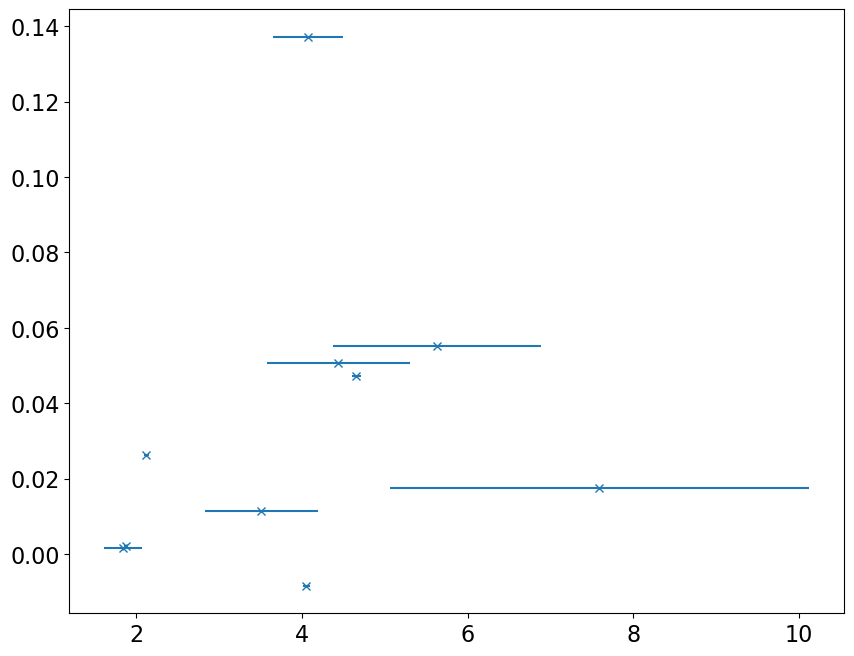

In [47]:
pl.errorbar(u.Quantity(wavelengths, u.um), u.Quantity([u.Quantity(x, u.Jy) for x in fluxes], u.Jy), xerr=widths, linestyle='none', marker='x')

# TODO: figure out where the green spitzer sources are

and what they are


Are they 4.5 micron excess?

5-8 micron dropout?

what?

In [78]:
bright_green_star_list = ['0604691', '0608824', '0611502', '0613733', '0611429', '0612623', '0613626', '0612695']

In [50]:
spitzer.add_index('SSTGC')

In [51]:
selind = spitzer.loc[bright_green_star_list[0]]
selind

<Row index=0>
 SSTGC    RAJ2000     DEJ2000     Jmag    Hmag    Ksmag   _3.6mag _4.5mag _5.8mag _8.0mag IRAC _2M 
          'h:m:s'     'd:m:s'     mag     mag      mag      mag     mag     mag     mag            
  str7     str11       str11    float32 float32  float32  float32 float32 float32 float32 str4 str2
------- ----------- ----------- ------- -------- -------- ------- ------- ------- ------- ---- ----
0604691 17 46 08.93 -28 41 22.5  15.819   14.663   12.374  10.953   8.864   8.285   8.895 IRAC   2M

In [58]:
from astropy.coordinates import SkyCoord

/orange/adamginsburg/miniconda3/envs/python39/lib/python3.9/site-packages/astropy/units/quantity.py:502: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  value = np.array(value, dtype=dtype, copy=copy, order=order,


Text(0.5, 1.0, '0604691')

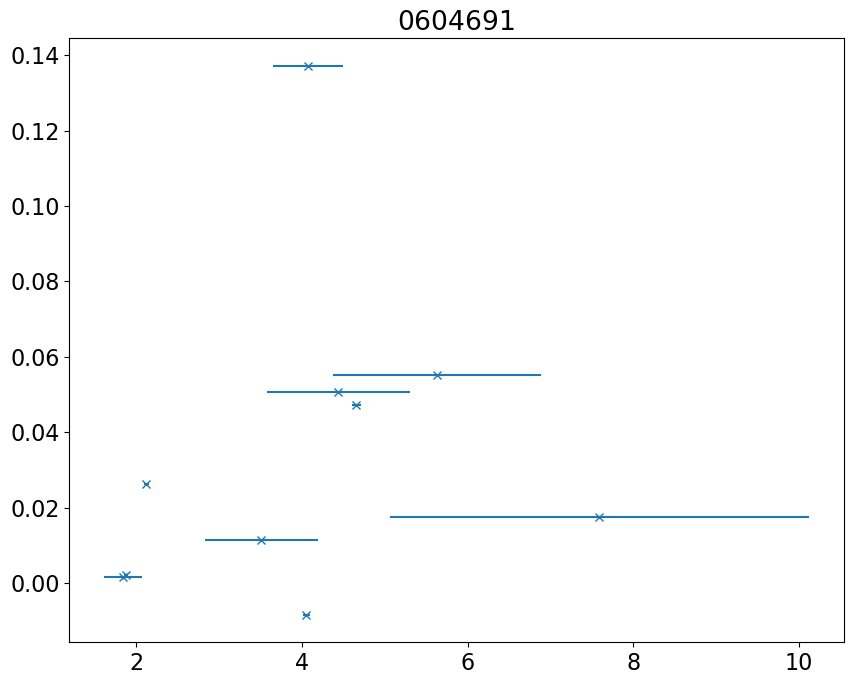

In [137]:
starid = bright_green_star_list[0]
selstar = spitzer.loc[starid]
coord = SkyCoord(selstar['RAJ2000'], selstar['DEJ2000'], frame='fk5', unit=(u.h, u.deg))
wavelengths, widths, fluxes = make_sed(coord, basetable=basetable, radius=1*u.arcsec)
pl.errorbar(u.Quantity(wavelengths, u.um), u.Quantity([u.Quantity(x, u.Jy) for x in fluxes], u.Jy), xerr=widths, linestyle='none', marker='x')
pl.title(starid)

1
1


/orange/adamginsburg/miniconda3/envs/python39/lib/python3.9/site-packages/astropy/units/quantity.py:502: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  value = np.array(value, dtype=dtype, copy=copy, order=order,


Text(0.5, 1.0, '0608824')

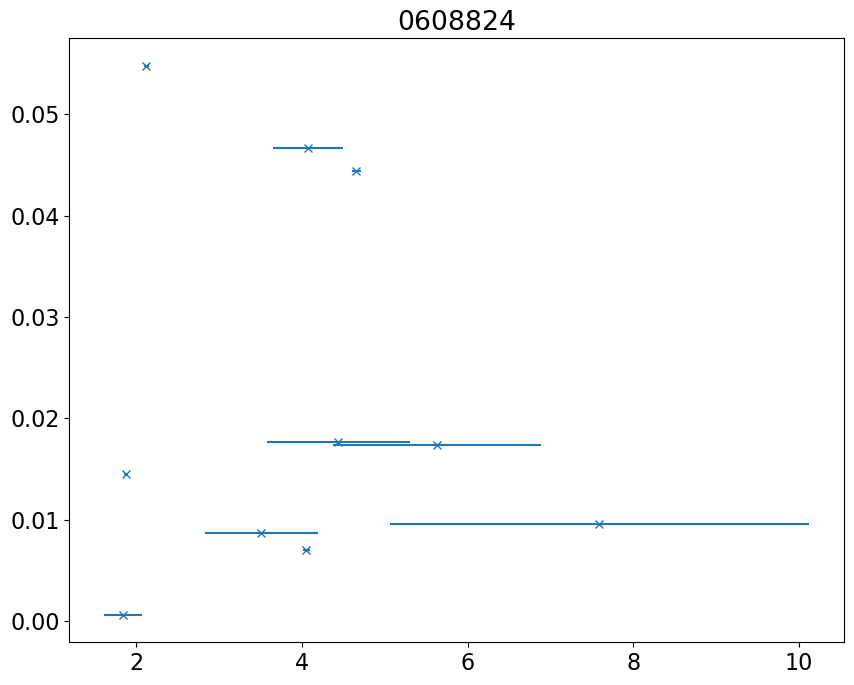

In [69]:
starid = bright_green_star_list[1]
selstar = spitzer.loc[starid]
coord = SkyCoord(selstar['RAJ2000'], selstar['DEJ2000'], frame='fk5', unit=(u.h, u.deg))
wavelengths, widths, fluxes = make_sed(coord, basetable=basetable, radius=1*u.arcsec)
pl.errorbar(u.Quantity(wavelengths, u.um), u.Quantity([u.Quantity(x, u.Jy) for x in fluxes], u.Jy), xerr=widths, linestyle='none', marker='x')
pl.title(starid)

In [73]:
widths

[<Quantity 4262.85790239 Angstrom>,
 <Quantity 274.27440341 Angstrom>,
 <Quantity 535.40523943 Angstrom>,
 <Quantity 454.87184789 Angstrom>,
 <Quantity 236.68645057 Angstrom>,
 <Quantity 2250.8124937 Angstrom>,
 <Quantity 6836.18018646 Angstrom>,
 <Quantity 8649.92060205 Angstrom>,
 <Quantity 12561.17490202 Angstrom>,
 <Quantity 25288.49843082 Angstrom>]

1
1


/orange/adamginsburg/miniconda3/envs/python39/lib/python3.9/site-packages/astropy/units/quantity.py:502: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  value = np.array(value, dtype=dtype, copy=copy, order=order,


Text(0.5, 1.0, '0611502')

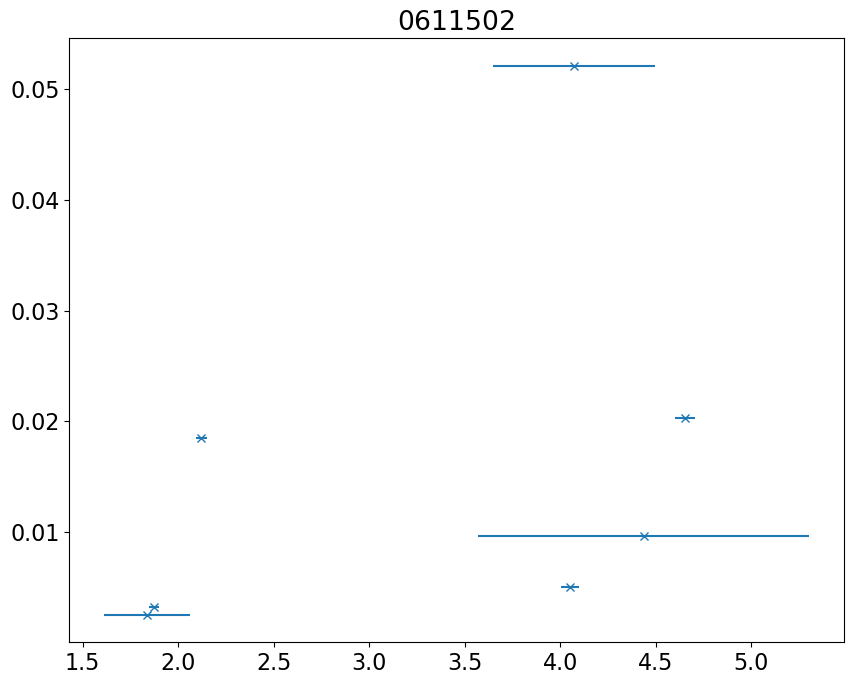

In [74]:
starid = bright_green_star_list[2]
selstar = spitzer.loc[starid]
coord = SkyCoord(selstar['RAJ2000'], selstar['DEJ2000'], frame='fk5', unit=(u.h, u.deg))
wavelengths, widths, fluxes = make_sed(coord, basetable=basetable, radius=1*u.arcsec)
fluxes = u.Quantity([u.Quantity(x, u.Jy) for x in fluxes], u.Jy)
ok = fluxes != 10*u.Jy
pl.errorbar(u.Quantity(wavelengths, u.um)[ok],
            fluxes[ok],
            xerr=u.Quantity(widths, u.Angstrom)[ok], linestyle='none', marker='x')
pl.title(starid)

1
1


/orange/adamginsburg/miniconda3/envs/python39/lib/python3.9/site-packages/astropy/units/quantity.py:502: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  value = np.array(value, dtype=dtype, copy=copy, order=order,


Text(0.5, 1.0, '0613733')

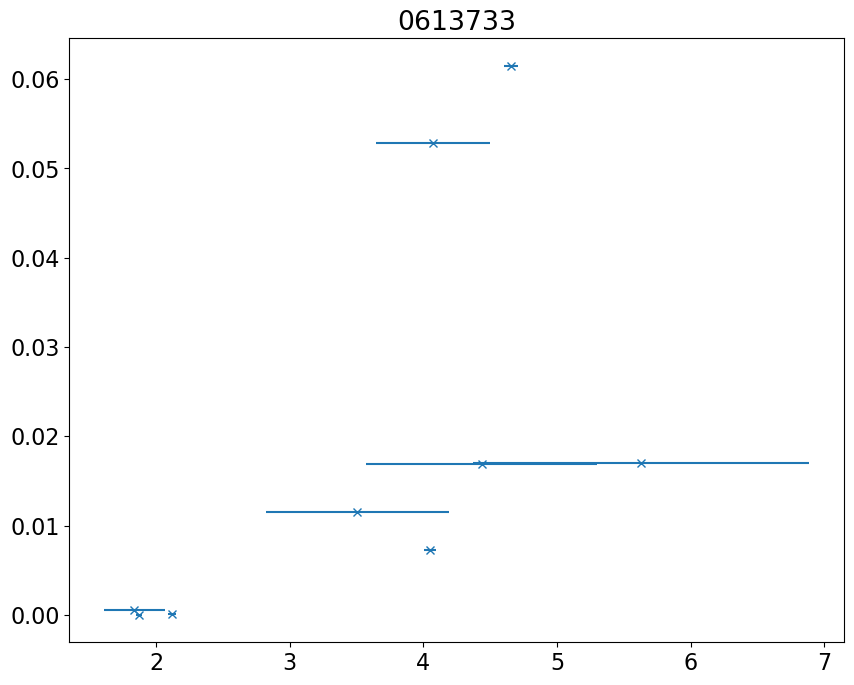

In [75]:
starid = bright_green_star_list[3]
selstar = spitzer.loc[starid]
coord = SkyCoord(selstar['RAJ2000'], selstar['DEJ2000'], frame='fk5', unit=(u.h, u.deg))
wavelengths, widths, fluxes = make_sed(coord, basetable=basetable, radius=1*u.arcsec)
fluxes = u.Quantity([u.Quantity(x, u.Jy) for x in fluxes], u.Jy)
ok = fluxes != 10*u.Jy
pl.errorbar(u.Quantity(wavelengths, u.um)[ok],
            fluxes[ok],
            xerr=u.Quantity(widths, u.Angstrom)[ok], linestyle='none', marker='x')
pl.title(starid)

1
1


/orange/adamginsburg/miniconda3/envs/python39/lib/python3.9/site-packages/astropy/units/quantity.py:502: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  value = np.array(value, dtype=dtype, copy=copy, order=order,


Text(0.5, 1.0, '0611429')

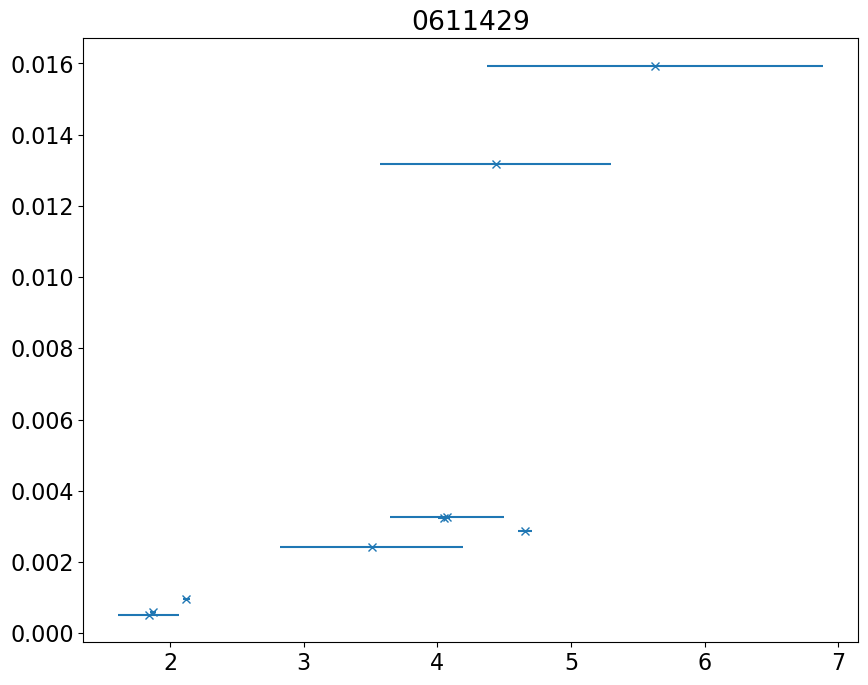

In [76]:
starid = bright_green_star_list[4]
selstar = spitzer.loc[starid]
coord = SkyCoord(selstar['RAJ2000'], selstar['DEJ2000'], frame='fk5', unit=(u.h, u.deg))
wavelengths, widths, fluxes = make_sed(coord, basetable=basetable, radius=1*u.arcsec)
fluxes = u.Quantity([u.Quantity(x, u.Jy) for x in fluxes], u.Jy)
ok = fluxes != 10*u.Jy
pl.errorbar(u.Quantity(wavelengths, u.um)[ok],
            fluxes[ok],
            xerr=u.Quantity(widths, u.Angstrom)[ok], linestyle='none', marker='x')
pl.title(starid)

1
1


/orange/adamginsburg/miniconda3/envs/python39/lib/python3.9/site-packages/astropy/units/quantity.py:502: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  value = np.array(value, dtype=dtype, copy=copy, order=order,


Text(0.5, 1.0, '0613626')

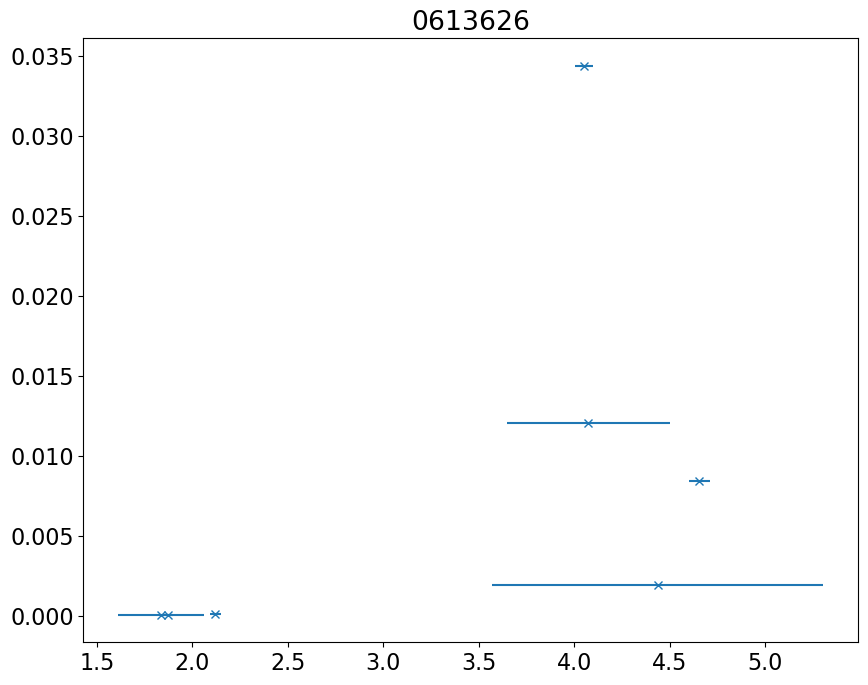

In [80]:
starid = bright_green_star_list[6]
selstar = spitzer.loc[starid]
coord = SkyCoord(selstar['RAJ2000'], selstar['DEJ2000'], frame='fk5', unit=(u.h, u.deg))
wavelengths, widths, fluxes = make_sed(coord, basetable=basetable, radius=1*u.arcsec)
fluxes = u.Quantity([u.Quantity(x, u.Jy) for x in fluxes], u.Jy)
ok = fluxes != 10*u.Jy
pl.errorbar(u.Quantity(wavelengths, u.um)[ok],
            fluxes[ok],
            xerr=u.Quantity(widths, u.Angstrom)[ok], linestyle='none', marker='x')
pl.title(starid)

In [185]:
ls -lhrt ../regions/green_spitzer_stars.reg

-rw-r--r-- 1 adamginsburg adamginsburg 1.9K Dec 23 18:05 ../regions/green_spitzer_stars.reg


In [268]:
import sys, imp
sys.path.append(f'{basepath}/analysis/')
sys.path.append(f'{basepath}/reduction/')
import plot_tools
imp.reload(plot_tools)
from plot_tools import starzoom, make_sed, starzoom_spitzer

In [269]:
def starzoom_(x):
    starzoom(x)
    starzoom_spitzer(x)

In [238]:
greenstarregs = regions.Regions.read('../regions/green_spitzer_stars.reg')
greenstarregcenters = SkyCoord([gs.center for gs in greenstarregs])

In [239]:
coord.separation(greenstarregcenters).to(u.arcsec)

<Angle [9.82204264e-03, 3.11385963e+01, 5.26804705e+01, 3.51352338e+01,
        3.99120694e+01, 3.61189149e+01, 6.80223427e+01, 8.83244831e+01,
        1.18280704e+02, 1.16723837e+02, 1.22098522e+02, 1.44184404e+02,
        1.56317899e+02, 1.48005690e+02, 1.71421608e+02, 1.88187137e+02,
        1.86802323e+02, 1.64245678e+02, 2.18218012e+02, 1.17947816e+02,
        3.48949640e+01, 3.61286230e+01, 3.81694982e+01, 4.04649583e+01,
        4.27734716e+01, 5.14963716e+01, 3.14707389e+01] arcsec>

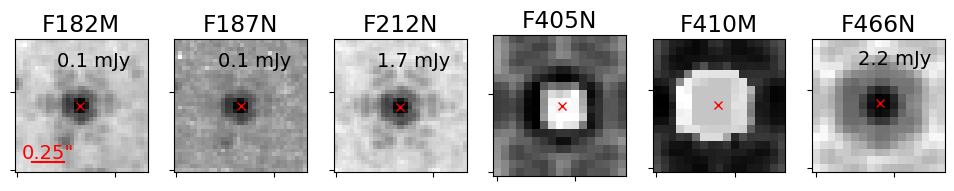

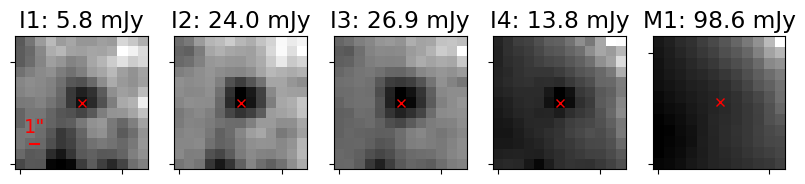

In [270]:
starzoom_(greenstarregs[0].center.fk5)

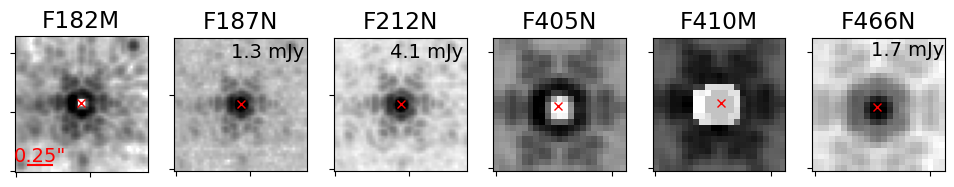

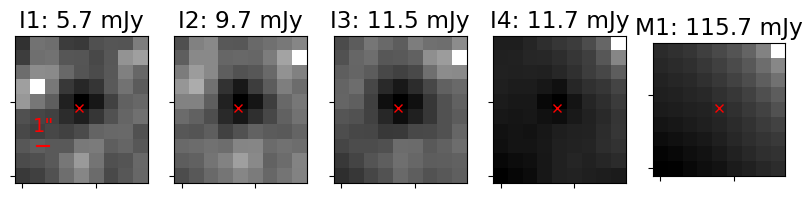

In [271]:
starzoom_(greenstarregs[1].center)

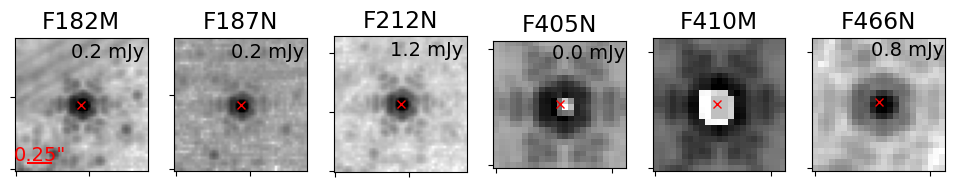

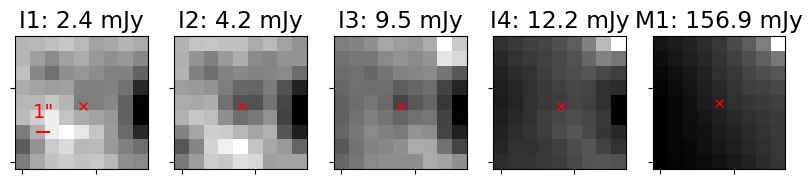

In [272]:
starzoom_(greenstarregs[2].center)

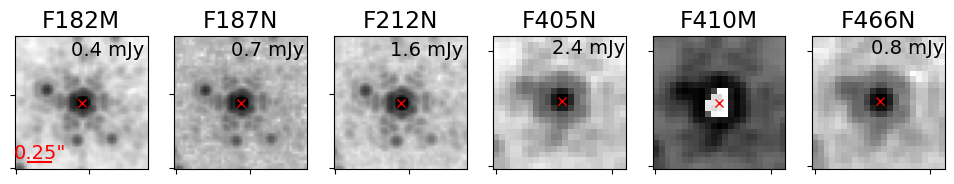

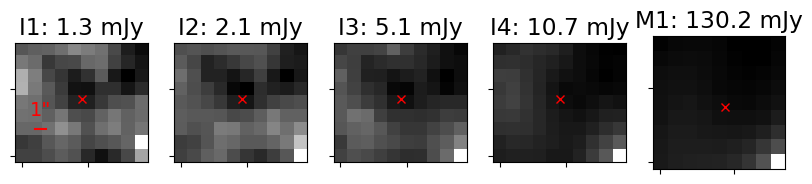

In [273]:
starzoom_(greenstarregs[3].center)

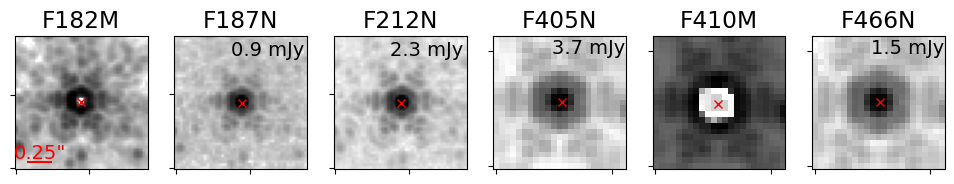

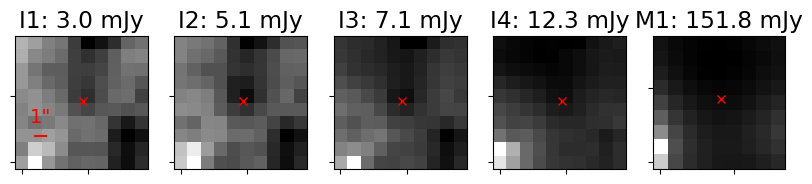

In [274]:
starzoom_(greenstarregs[4].center)

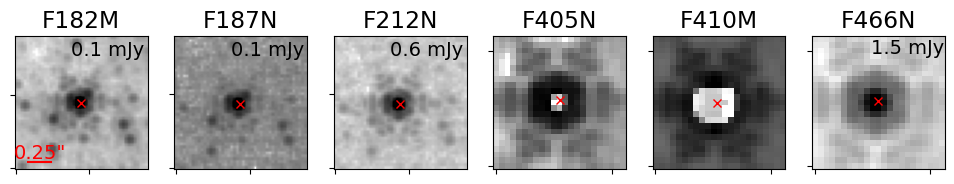

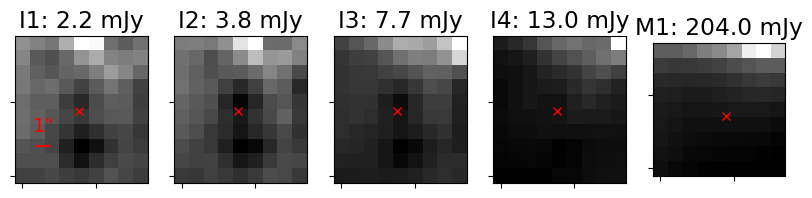

In [275]:
starzoom_(greenstarregs[5].center)

<SkyCoord (Galactic): (l, b) in deg
    (0.2613465, 0.013149)>

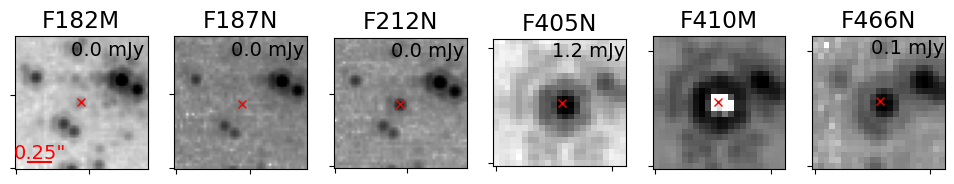

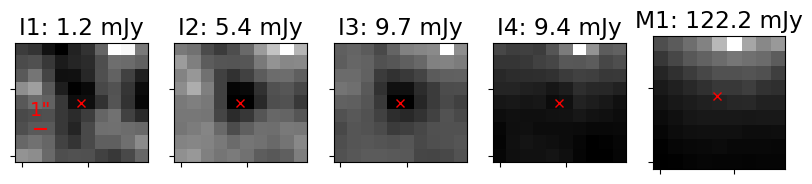

In [276]:
starzoom_(greenstarregs[6].center)
greenstarregs[6].center

<SkyCoord (Galactic): (l, b) in deg
    (0.2588993, 0.0080538)>

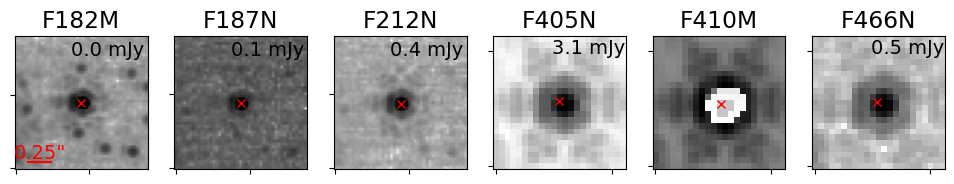

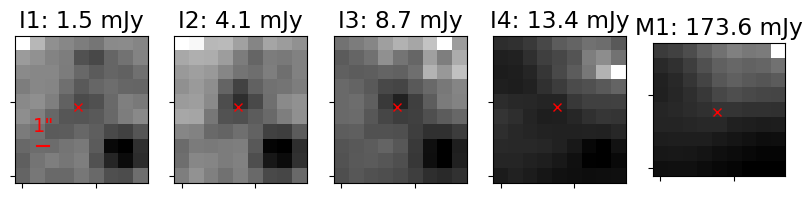

In [277]:
starzoom_(greenstarregs[7].center)
greenstarregs[7].center

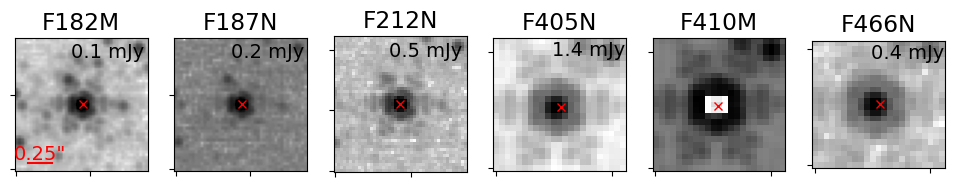

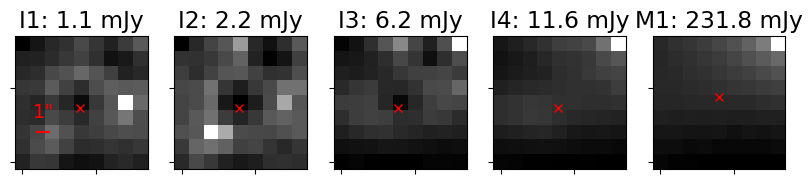

In [278]:
starzoom_(greenstarregs[8].center)

<SkyCoord (Galactic): (l, b) in deg
    (0.2501965, 0.0044776)>

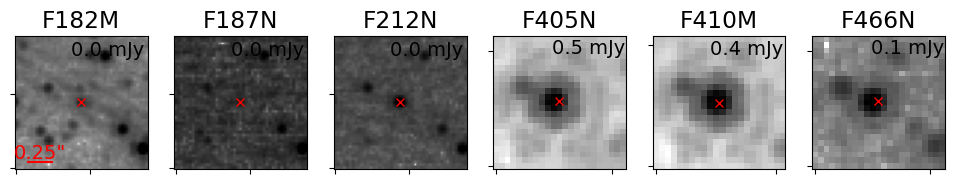

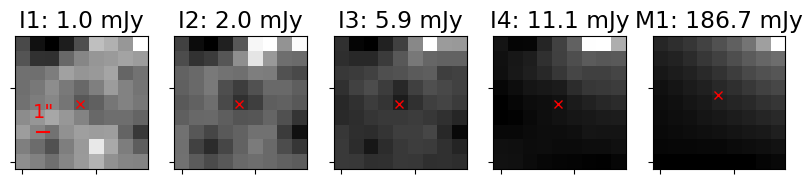

In [279]:
starzoom_(greenstarregs[9].center)
greenstarregs[9].center

<SkyCoord (Galactic): (l, b) in deg
    (0.2487719, 0.0037243)>

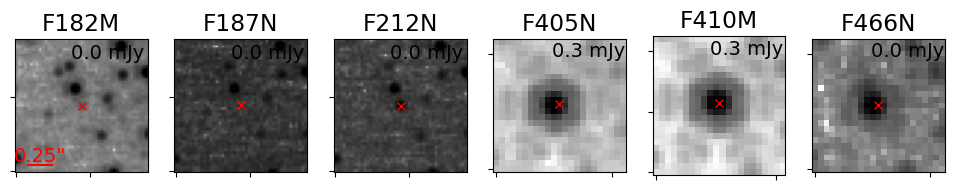

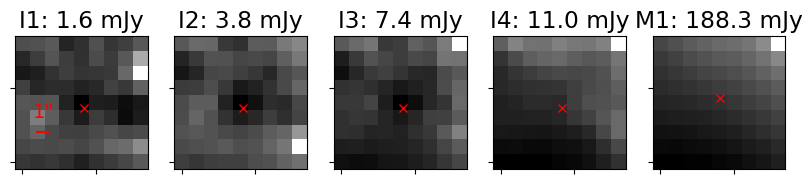

In [280]:
starzoom_(greenstarregs[10].center)
greenstarregs[10].center

<SkyCoord (Galactic): (l, b) in deg
    (0.2441802, -0.0004108)>

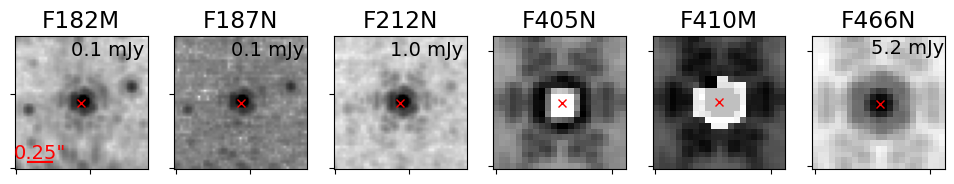

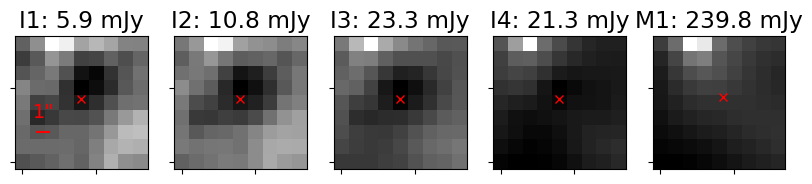

In [281]:
starzoom_(greenstarregs[11].center)
greenstarregs[11].center

<SkyCoord (Galactic): (l, b) in deg
    (0.2371447, 0.0020825)>

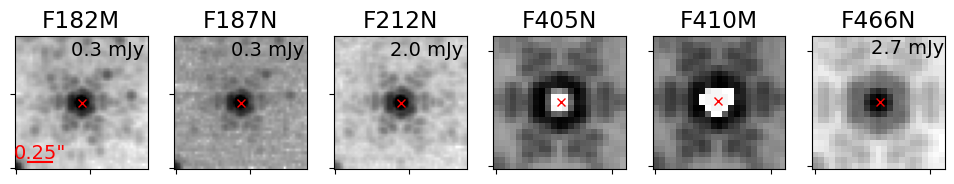

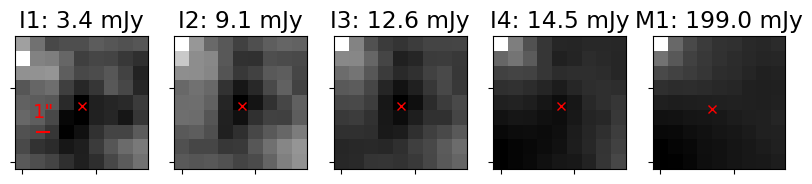

In [282]:
starzoom_(greenstarregs[12].center)
greenstarregs[12].center

<SkyCoord (Galactic): (l, b) in deg
    (0.2397733, 0.0025438)>

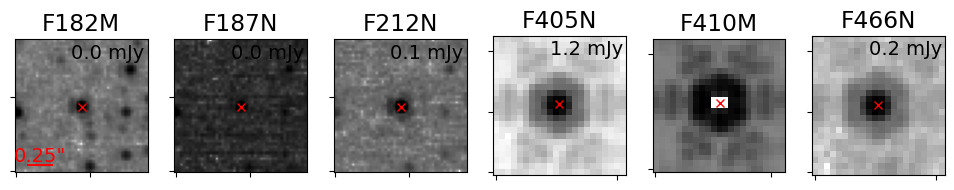

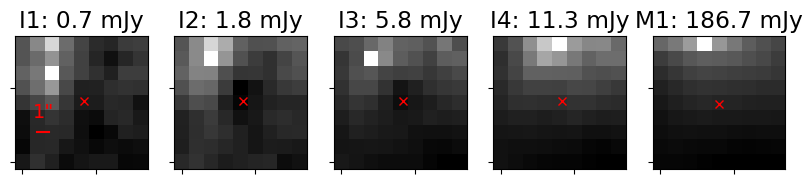

In [283]:
starzoom_(greenstarregs[13].center)
greenstarregs[13].center

<SkyCoord (Galactic): (l, b) in deg
    (0.2341759, -0.0009127)>

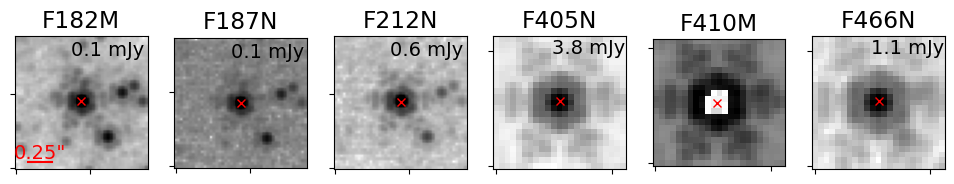

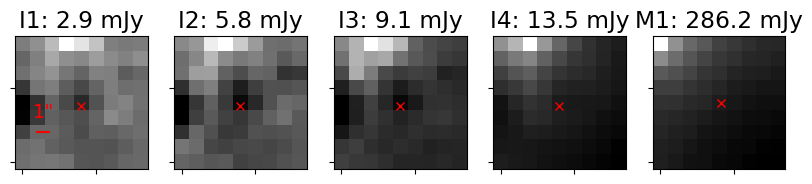

In [284]:
starzoom_(greenstarregs[14].center)
greenstarregs[14].center

<SkyCoord (Galactic): (l, b) in deg
    (0.2300046, -0.003166)>

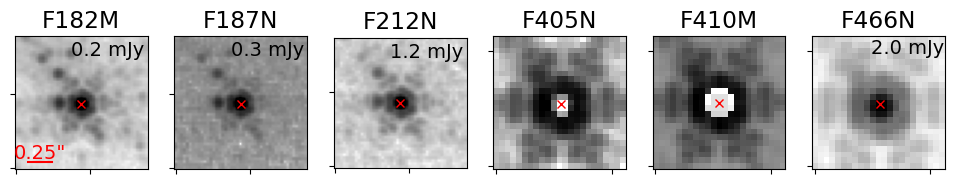

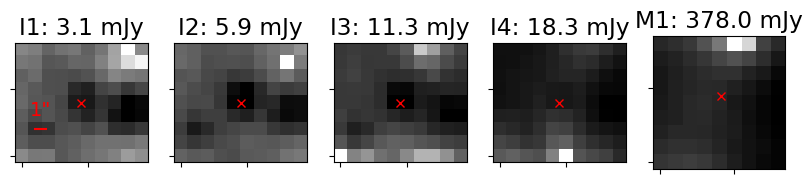

In [285]:
starzoom_(greenstarregs[15].center)
greenstarregs[15].center

<SkyCoord (Galactic): (l, b) in deg
    (0.2311767, -0.0039857)>

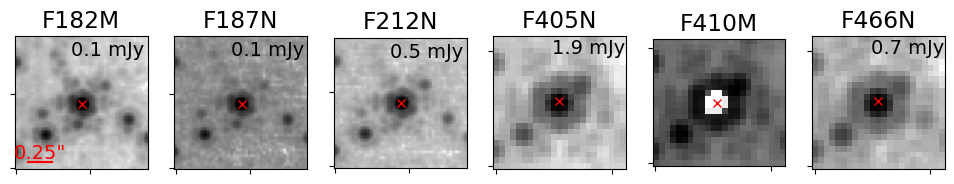

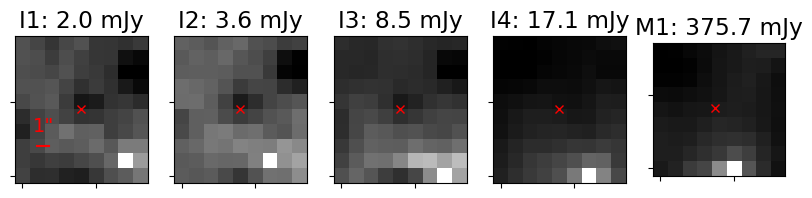

In [286]:
starzoom_(greenstarregs[16].center)
greenstarregs[16].center

<SkyCoord (Galactic): (l, b) in deg
    (0.2330941, 0.0038361)>

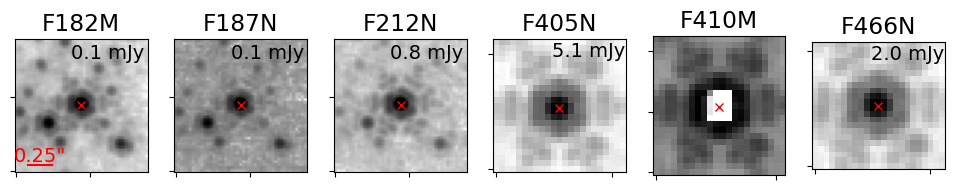

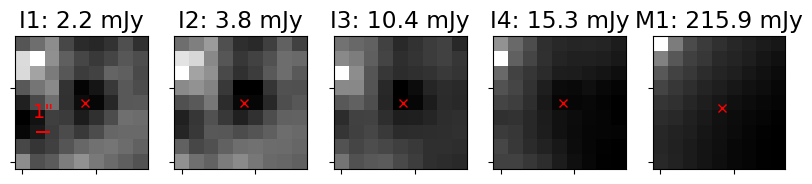

In [287]:
starzoom_(greenstarregs[17].center)
greenstarregs[17].center

<SkyCoord (Galactic): (l, b) in deg
    (0.2272421, -0.0126387)>

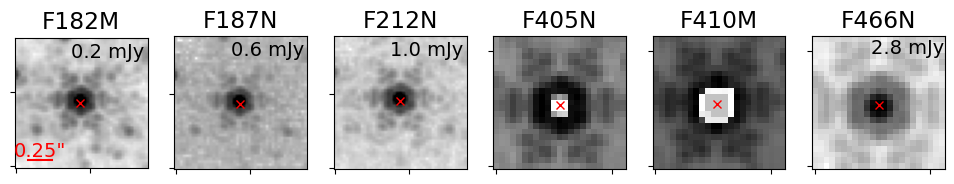

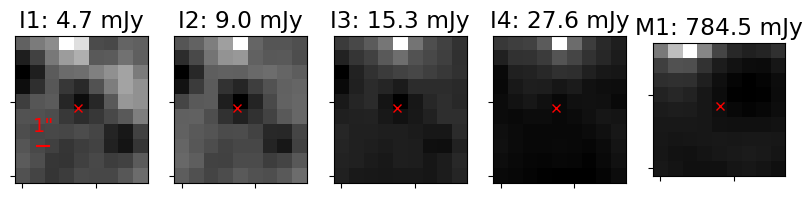

In [288]:
starzoom_(greenstarregs[18].center)
greenstarregs[18].center

<SkyCoord (Galactic): (l, b) in deg
    (0.2490355, 0.0050243)>

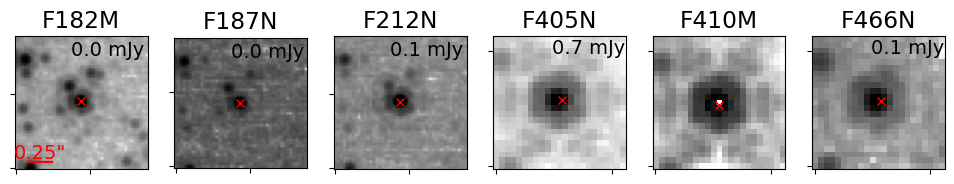

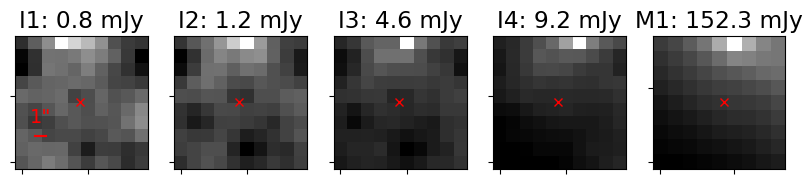

In [289]:
cen = greenstarregs[19].center
starzoom_(cen)
cen

<SkyCoord (Galactic): (l, b) in deg
    (0.2660201, 0.0210765)>

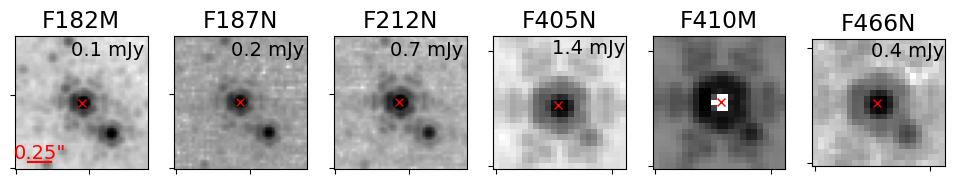

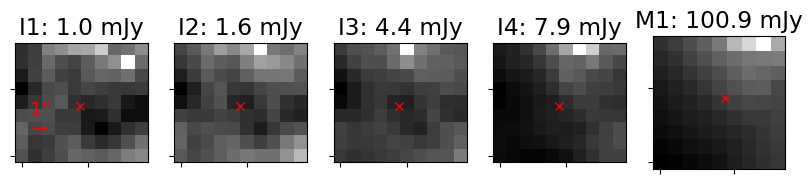

In [290]:
cen = greenstarregs[20].center
starzoom_(cen)
cen

Set DATE-AVG to '2022-08-28T03:05:32.473' from MJD-AVG.
Set DATE-END to '2022-08-28T03:34:03.557' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -20.651775 from OBSGEO-[XYZ].
Set OBSGEO-H to 1526292809.682 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


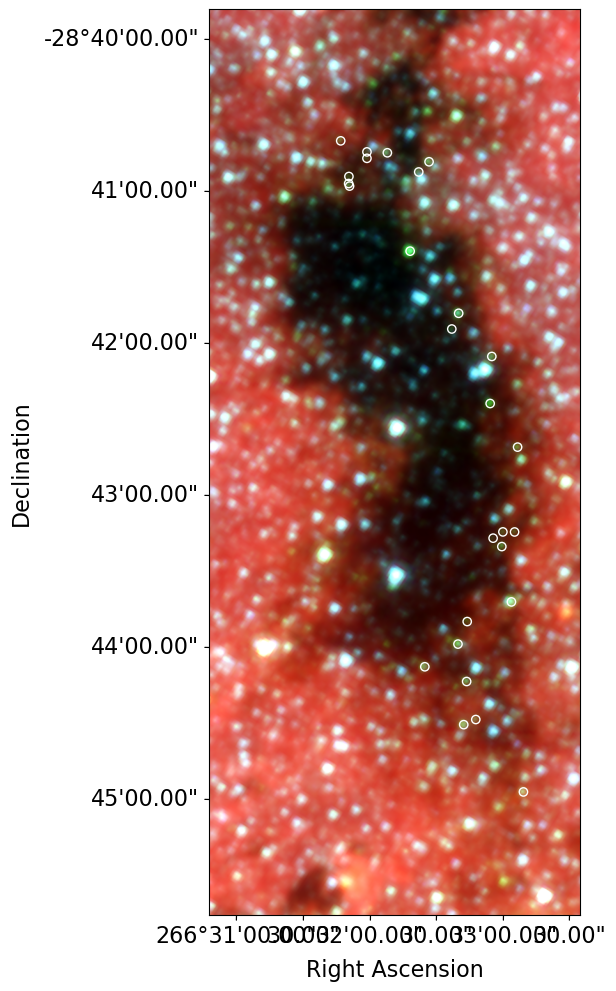

In [209]:
avm = pyavm.AVM.from_image(f'{basepath}/images/BrickSpitzer_RGB_I421.png')
img_spitzer = np.array(PIL.Image.open(f'{basepath}/images/BrickSpitzer_RGB_I421.png'))[::-1,:,:]
wwi_spitzer = wcs.WCS(fits.Header.fromstring(avm.Spatial.FITSheader))

img_spitzer = img_spitzer.swapaxes(0,1)
wwi_spitzer = wwi_spitzer.sub([2,1])

fig = pl.figure(figsize=(12,12))
ax = pl.subplot(projection=wwi_spitzer)
ax.imshow(img_spitzer)
axlims = ax.axis()

xx,yy = wwi_spitzer.world_to_pixel(greenstarregcenters)
ax.scatter(
    xx,yy,
    #spitzer_crds.ra[spitzer['_4.5mag'] - spitzer['_8.0mag'] < 0],
    #spitzer_crds.dec[spitzer['_4.5mag'] - spitzer['_8.0mag'] < 0],
    #transform=ax.get_transform('fk5'),
    marker='o', edgecolors='w', facecolors='none',
    #markeredgewidth=0.5,
    # for non-x facecolors='none'
    #edgecolors=(0.3, 0.5, 0.8), a 
);

#ax.scatter(crds.ra[blue_410_405], crds.dec[blue_410_405], edgecolors='orange', facecolors='none', transform=ax.get_transform('world'))
ax.coords['ra'].set_axislabel('Right Ascension')
ax.coords['dec'].set_axislabel('Declination')

ra = lon = ax.coords['ra']
dec = lat = ax.coords['dec']
lon.set_major_formatter('dd:mm:ss.ss')
lat.set_major_formatter('dd:mm:ss.ss')
#lon.set_ticks(spacing=30. * u.arcsec, color='red')
#lat.set_ticks(spacing=30. * u.arcsec, color='blue')
#lon.set_ticklabel(color='red')
#lat.set_ticklabel(color='blue')
#lon.grid(color='red')
#lat.grid(color='blue')

ax.axis(axlims)

dec.set_ticks_position('l')
dec.set_ticklabel_position('l')
dec.set_axislabel_position('l')
ra.set_ticks_position('b')
ra.set_ticklabel_position('b')
ra.set_axislabel_position('b')
#fig.savefig(f"{basepath}/images/BlueStarsWithSpitzerMatches_on_RGB.png", bbox_inches='tight')

In [ ]:
spitzer[:1]

In [ ]:
basetable[:2]

In [ ]:
SvoFps.get_filter_list(facility="JWST", instrument="NIRCAM")[:1]

# not (yet) used

In [ ]:
vvvdr2 = Vizier.query_region(coordinates=coord, width=width, height=height, catalog=['II/348/vvv2'])[0]
vvvdr2_crds = SkyCoord(vvvdr2['RAJ2000'], vvvdr2['DEJ2000'], frame='fk5')
idx, sidx, sep, sep3d = vvvdr2_crds.search_around_sky(skycrds_cat, 0.2*u.arcsec)

In [ ]:
twomass_crds = SkyCoord(twomass['RAJ2000'], twomass['DEJ2000'], frame='fk5')

In [ ]:
spitzer.add_column(col=spitzer_crds, name='coordinates')
spitzer.write('/orange/adamginsburg/spitzer/cmz_catalog_II_295_SSTGC_Ramirez2008.fits', overwrite=True)
len(spitzer)

In [ ]:
spitzer

# An2011 Vizier

In [ ]:
an2011 = Vizier(row_limit=500).get_catalogs(['J/ApJ/736/133/table1'])[0]

In [ ]:
an2011crds = SkyCoord(an2011['RAJ2000'], an2011['DEJ2000'], frame='fk5', unit=(u.h, u.deg))

In [ ]:
an2011[wwi_spitzer.footprint_contains(an2011crds)]

In [ ]:
# This image shows only H-alpha stars
avm = pyavm.AVM.from_image(f'{basepath}/images/BrickSpitzer_RGB_I421.png')
img_spitzer = np.array(PIL.Image.open(f'{basepath}/images/BrickSpitzer_RGB_I421.png'))[::-1,:,:]
#wwi_bra_410 = avm.to_wcs(use_full_header=True)
wwi_spitzer = wcs.WCS(fits.Header.fromstring(avm.Spatial.FITSheader))

img_spitzer = img_spitzer.swapaxes(0,1)
wwi_spitzer = wwi_spitzer.sub([2,1])

fig = pl.figure(figsize=(12,12))
ax = pl.subplot(projection=wwi_spitzer)
ax.imshow(img_spitzer)
axlims = ax.axis()

xx,yy = wwi_spitzer.world_to_pixel(an2011crds[wwi_spitzer.footprint_contains(an2011crds)])
ax.scatter(
    xx,yy,
    #spitzer_crds.ra[spitzer['_4.5mag'] - spitzer['_8.0mag'] < 0],
    #spitzer_crds.dec[spitzer['_4.5mag'] - spitzer['_8.0mag'] < 0],
    #transform=ax.get_transform('fk5'),
    marker='o', edgecolors='black', facecolors='none',
    #markeredgewidth=0.5,
    # for non-x facecolors='none'
    #edgecolors=(0.3, 0.5, 0.8), a 
);
ax.scatter(
    xx,yy,
    s=20,
    marker='o', edgecolors='g', facecolors='none',
);
#ax.scatter(crds.ra[blue_410_405], crds.dec[blue_410_405], edgecolors='orange', facecolors='none', transform=ax.get_transform('world'))
ax.coords['ra'].set_axislabel('Right Ascension')
ax.coords['dec'].set_axislabel('Declination')

ra = lon = ax.coords['ra']
dec = lat = ax.coords['dec']
lon.set_major_formatter('hh:mm:ss.ss')
lat.set_major_formatter('dd:mm:ss.ss')
lon.set_ticks(spacing=30. * u.arcsec)
lon.set_ticklabel(rotation=45, pad=60)
#lat.set_ticks(spacing=30. * u.arcsec, color='blue')



#ax.axis(axlims)

dec.set_ticks_position('l')
dec.set_ticklabel_position('l')
dec.set_axislabel_position('l')
ra.set_ticks_position('b')
ra.set_ticklabel_position('b')
ra.set_axislabel_position('b')
#fig.savefig(f"{basepath}/images/BlueStarsWithSpitzerMatches_on_RGB.png", bbox_inches='tight')